In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 0 for the experiment.


In [9]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import keras as keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Print the list of available GPUs
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
#Prepare Training Data:
path_to_X = "./Normalised/X.npy"
path_to_Y = "./Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [5]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full autoencoder model
    autoencoder_outputs = decoder_model(encoder_lstm)
    autoencoder = Model(encoder_inputs, autoencoder_outputs)
    
    # Compile the model
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    autoencoder.summary()
    return autoencoder

In [6]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:0'):
        save_path = "./Saved_Models_Data/P50_U32_OA/"
        autoencoder = createModel(32,'adam')
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = autoencoder.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history.json','w') as file:
            json.dump(history.history, file)
else:
    print("No GPU available.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-12 13:04:56.315893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 model_1 (Functional)        (None, 81, 1)             8353      
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2023-11-12 13:05:00.580236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-12 13:05:00.710630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-12 13:05:00.711277: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef188174820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-12 13:05:00.711317: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-12 13:05:00.718429: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-12 13:05:00.836165: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1242/1244 [============================>.] - ETA: 0s - loss: 0.1179 - mae: 0.2365
Epoch 1: val_loss improved from inf to 0.09215, saving model to ./Saved_Models_Data/P50_U32_OA/best_enc_dec.h5
1244/1244 [==============================] - 17s 11ms/step - loss: 0.1179 - mae: 0.2364 - val_loss: 0.0922 - val_mae: 0.1777
Epoch 2/200
  17/1244 [..............................] - ETA: 12s - loss: 0.0915 - mae: 0.1817

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1242/1244 [============================>.] - ETA: 0s - loss: 0.0949 - mae: 0.1849
Epoch 2: val_loss did not improve from 0.09215
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0949 - mae: 0.1849 - val_loss: 0.0969 - val_mae: 0.1896
Epoch 3/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0871 - mae: 0.1772
Epoch 3: val_loss improved from 0.09215 to 0.08345, saving model to ./Saved_Models_Data/P50_U32_OA/best_enc_dec.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0871 - mae: 0.1772 - val_loss: 0.0834 - val_mae: 0.1711
Epoch 4/200
1239/1244 [============================>.] - ETA: 0s - loss: 0.1159 - mae: 0.2251
Epoch 4: val_loss did not improve from 0.08345
1244/1244 [==============================] - 14s 11ms/step - loss: 0.1159 - mae: 0.2252 - val_loss: 0.1236 - val_mae: 0.2502
Epoch 5/200
1242/1244 [============================>.] - ETA: 0s - loss: 0.1132 - mae: 0.2294
Epoch 5: val_loss did not improve from 0.08345
1244/

In [7]:
save_path = "./Saved_Models_Data/P50_U32_OA/"
f = open(save_path+"history.json")
history = json.load(f)

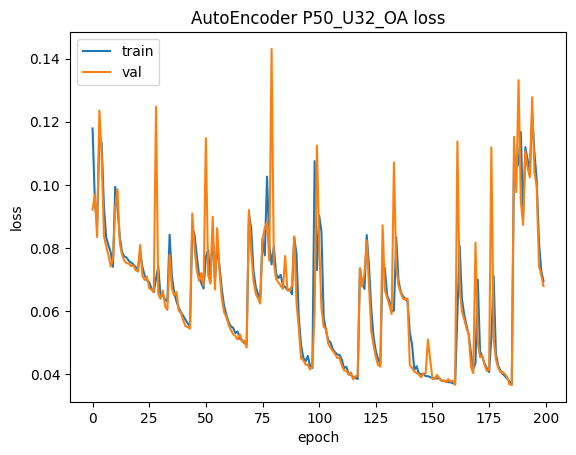

In [8]:
# summarize history for loss
mod_name = "P50_U32_OA"
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('AutoEncoder '+mod_name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
#Evaluate the saved best model:
from keras.models import load_model
saved_model = load_model(save_path+"best_enc_dec.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 5ms/step - loss: 0.0365 - mae: 0.0650
Mean Squared Error:  0.03652219474315643
Mean Absolute Error:  0.0650230199098587
Root Mean Squared Error (RMSE):  0.1911078092155222


In [11]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth.npy", Y_test)

389/389 [==============================] - 2s 5ms/step


In [12]:
#print some samples
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path +"ground-truth.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.036184925585985184
Index 1 Ground truth: 0 Predicted: 0.14545977115631104
Index 2 Ground truth: 1 Predicted: 0.9059617519378662
Index 3 Ground truth: 0 Predicted: 0.0021199651528149843
Index 4 Ground truth: 0 Predicted: 0.0002595110854599625
Index 5 Ground truth: 0 Predicted: 2.3962027626112103e-05
Index 6 Ground truth: 0 Predicted: 0.00011674064444378018
Index 7 Ground truth: 0 Predicted: 0.00032321916660293937
Index 8 Ground truth: 0 Predicted: 0.00024701139773242176
Index 9 Ground truth: 0 Predicted: 0.004105575382709503
Index 10 Ground truth: 0 Predicted: 2.1107919110363582e-06
Index 11 Ground truth: 0 Predicted: 0.0003481752937659621
Index 12 Ground truth: 0 Predicted: 0.005340329837054014
Index 13 Ground truth: 1 Predicted: 0.9888983368873596
Index 14 Ground truth: 0 Predicted: 0.022929852828383446
Index 15 Ground truth: 0 Predicted: 0.00043775129597634077
Index 16 Ground truth: 0 Predicted: 0.0058211651630699

In [13]:
#Can convert to Benesh version for predictions using a threshold here (0.5)
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [14]:
#save the error array
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr.npy",err_arr)

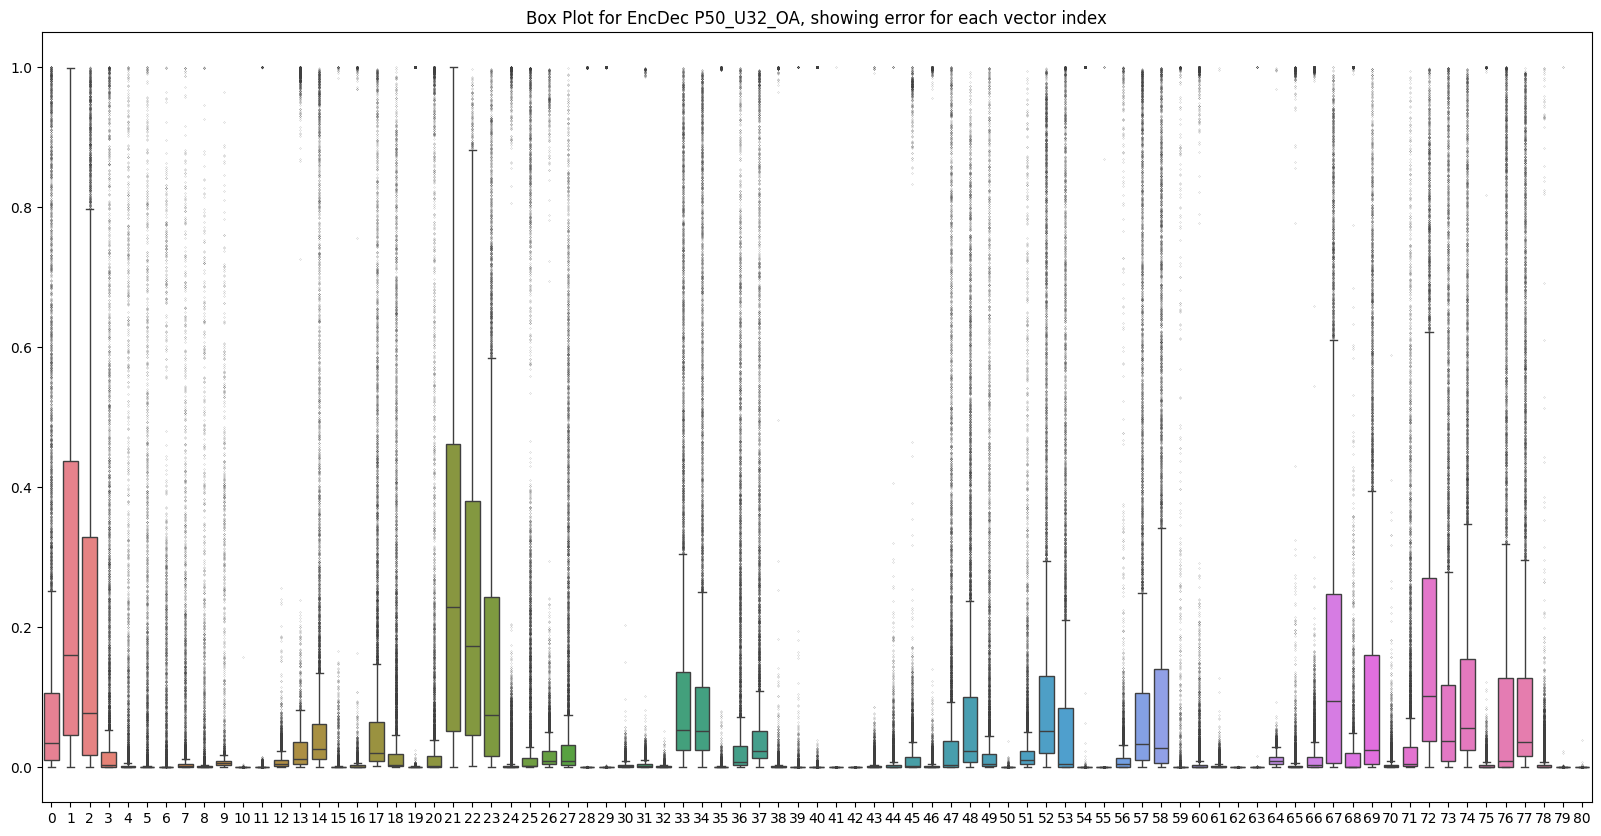

In [15]:
err_arr = np.load(save_path+"err_arr.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for EncDec '+mod_name+', showing error for each vector index')
plt.show()

In [16]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100 # Multiply by 100 to get the percentage
    print("OVERALL MAPE: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.04478694 0.04464202 0.05291106 0.05491845 0.08138869 0.0509898
 0.10367391 0.14758877 0.08002329 0.05316068]
OVERALL MAPE:  6.502302365000828


In [17]:
from sklearn.metrics import r2_score

In [18]:
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

In [19]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.84222802 0.81784232 0.84638814 ... 0.64658608 0.74925523 0.66869298]
Overall R-squared value: 0.7106013664348098


In [20]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.60792058 0.53508902 0.61089329 ... 0.55738439 0.58116613 0.49793006]
Overall Spearman correlation coefficient: 0.5496618554932996


In [21]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.91814566 0.9044321  0.92288956 ... 0.80730393 0.86820507 0.81807405]
12433
Overall Pearson correlation coefficient: 0.8418302843501182


In [22]:
from sklearn.metrics import matthews_corrcoef #calculated using the converted 0.5 threshold benesh vector
y_pred = np.load(save_path + "y_pred_benesh.npy")
y_true = np.load(save_path + "ground-truth.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.8149377536331489
